In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
# %pip install scikit-learn --quiet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
sns.set(style="whitegrid")

In [ ]:
# read data
df = pd.read_excel("Dataset.xlsx", sheet_name=0)
# df.head()

,student_id,name,class,study,gpa,greek,off_campus,distance_to_campus,gender,sprinklered,coverage,claim_id,amount,risk_tier,holdout
0,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Additional Living Expense,0,0.0,2,False
1,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Guest Medical,0,0.0,2,False
2,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Liability,0,0.0,2,False
3,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.0,Male,True,Personal Property,0,0.0,2,False
4,2,"Reddy, Dawna",Junior,Science,0.609616,Non-greek,On campus,0.0,Female,True,Additional Living Expense,0,0.0,2,False


In [3]:
df_loss = df[df["amount"] > 0].copy()

In [10]:
formula = """
amount ~ 
C(coverage)
+ C(greek, Treatment(reference='Non-greek'))
+ C(off_campus, Treatment(reference='On campus'))
+ C(sprinklered, Treatment(reference=True))
"""

gamma_model = smf.glm(
    formula=formula,
    data=df_loss,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()

print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 amount   No. Observations:                 1819
Model:                            GLM   Df Residuals:                     1812
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                         0.43432
Method:                          IRLS   Log-Likelihood:                -15640.
Date:                Sat, 29 Nov 2025   Deviance:                       814.27
Time:                        20:31:18   Pearson chi2:                     787.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.9569
Covariance Type:            nonrobust                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

c:\Users\ziang\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [11]:
scenario_df = pd.DataFrame({
    "coverage":     ["Personal Property", "Liability", "Liability", "Guest Medical"],
    "greek":        ["Non-greek", "Non-greek", "Greek", "Greek"],
    "off_campus":   ["On campus", "Off campus", "Off campus", "Off campus"],
    "sprinklered":  [True, True, True, False],
}, index=[
    "Scenario_A_MinRisk",
    "Scenario_B_ModerateRisk",
    "Scenario_C_HighRisk",
    "Scenario_D_Catastrophic"
])

print("\nScenario Table:")
print(scenario_df)


Scenario Table:
                                  coverage      greek  off_campus  sprinklered
Scenario_A_MinRisk       Personal Property  Non-greek   On campus         True
Scenario_B_ModerateRisk          Liability  Non-greek  Off campus         True
Scenario_C_HighRisk              Liability      Greek  Off campus         True
Scenario_D_Catastrophic      Guest Medical      Greek  Off campus        False


In [12]:
scenario_df["expected_loss"] = gamma_model.predict(scenario_df)

print("\nPredicted Expected Loss per Scenario:")
print(scenario_df)



Predicted Expected Loss per Scenario:
                                  coverage      greek  off_campus  \
Scenario_A_MinRisk       Personal Property  Non-greek   On campus   
Scenario_B_ModerateRisk          Liability  Non-greek  Off campus   
Scenario_C_HighRisk              Liability      Greek  Off campus   
Scenario_D_Catastrophic      Guest Medical      Greek  Off campus   

                         sprinklered  expected_loss  
Scenario_A_MinRisk              True     538.611460  
Scenario_B_ModerateRisk         True    6679.663218  
Scenario_C_HighRisk             True   13779.886816  
Scenario_D_Catastrophic        False   41124.658942  


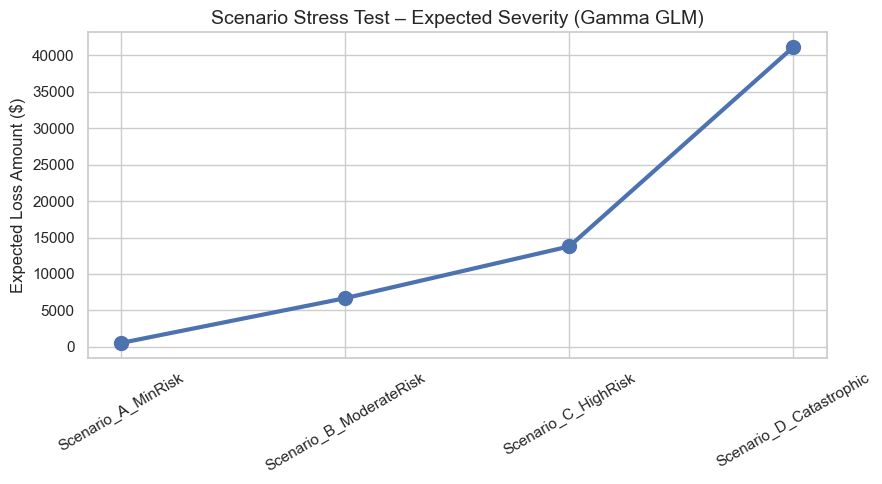

In [13]:
plt.figure(figsize=(9, 5))
plt.plot(
    scenario_df.index,
    scenario_df["expected_loss"],
    marker="o",
    linewidth=3,
    markersize=10
)

plt.title("Scenario Stress Test – Expected Severity (Gamma GLM)", fontsize=14)
plt.ylabel("Expected Loss Amount ($)", fontsize=12)
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def map_model_tier(x):
    if x < 10000:
        return 1
    elif x < 30000:
        return 2
    else:
        return 3

scenario_df["model_tier"] = scenario_df["expected_loss"].apply(map_model_tier)
scenario_df


,coverage,greek,off_campus,sprinklered,expected_loss,model_tier
Scenario_A_MinRisk,Personal Property,Non-greek,On campus,True,538.611460,1
Scenario_B_ModerateRisk,Liability,Non-greek,Off campus,True,6679.663218,1
Scenario_C_HighRisk,Liability,Greek,Off campus,True,13779.886816,2
Scenario_D_Catastrophic,Guest Medical,Greek,Off campus,False,41124.658942,3


In [17]:
# Scenario A
cond_A = (
    (df_loss["coverage"]=="Personal Property") &
    (df_loss["greek"]=="Non-greek") &
    (df_loss["off_campus"]=="On campus") &
    (df_loss["sprinklered"]==True)
)
df_A = df_loss[cond_A]

# Scenario B
cond_B = (
    (df_loss["coverage"]=="Liability") &
    (df_loss["greek"]=="Non-greek") &
    (df_loss["off_campus"]=="Off campus") &
    (df_loss["sprinklered"]==True)
)
df_B = df_loss[cond_B]

# Scenario C
cond_C = (
    (df_loss["coverage"]=="Liability") &
    (df_loss["greek"]=="Greek") &
    (df_loss["off_campus"]=="Off campus") &
    (df_loss["sprinklered"]==True)
)
df_C = df_loss[cond_C]

# Scenario D
cond_D = (
    (df_loss["coverage"]=="Guest Medical") &
    (df_loss["greek"]=="Greek") &
    (df_loss["off_campus"]=="Off campus") &
    (df_loss["sprinklered"]==False)
)
df_D = df_loss[cond_D]


In [18]:
print("Dataset Tier for Scenario A:")
print(df_A["risk_tier"].value_counts(normalize=True))

print("\nDataset Tier for Scenario B:")
print(df_B["risk_tier"].value_counts(normalize=True))

print("\nDataset Tier for Scenario C:")
print(df_C["risk_tier"].value_counts(normalize=True))

print("\nDataset Tier for Scenario D:")
print(df_D["risk_tier"].value_counts(normalize=True))


Dataset Tier for Scenario A:
risk_tier
1    0.478261
3    0.264493
2    0.257246
Name: proportion, dtype: float64

Dataset Tier for Scenario B:
risk_tier
2    0.411765
1    0.352941
3    0.235294
Name: proportion, dtype: float64

Dataset Tier for Scenario C:
risk_tier
1    0.6
3    0.4
Name: proportion, dtype: float64

Dataset Tier for Scenario D:
risk_tier
3    0.500
1    0.375
2    0.125
Name: proportion, dtype: float64


In [ ]:
# percentage comparison table
comparison = pd.DataFrame({
    "scenario": scenario_df.index,
    "model_expected_loss": scenario_df["expected_loss"].values,
    "model_tier": scenario_df["model_tier"].values,
    "dataset_tier1 (%)": [
        df_A["risk_tier"].eq(1).mean() * 100,
        df_B["risk_tier"].eq(1).mean() * 100,
        df_C["risk_tier"].eq(1).mean() * 100,
        df_D["risk_tier"].eq(1).mean() * 100
    ],
    "dataset_tier2 (%)": [
        df_A["risk_tier"].eq(2).mean() * 100,
        df_B["risk_tier"].eq(2).mean() * 100,
        df_C["risk_tier"].eq(2).mean() * 100,
        df_D["risk_tier"].eq(2).mean() * 100
    ],
    "dataset_tier3 (%)": [
        df_A["risk_tier"].eq(3).mean() * 100,
        df_B["risk_tier"].eq(3).mean() * 100,
        df_C["risk_tier"].eq(3).mean() * 100,
        df_D["risk_tier"].eq(3).mean() * 100
    ]
}).round(1)


# Merge scenario_df and comparison
final_table = scenario_df.merge(
    comparison,
    left_index=True,
    right_on="scenario"
)

# put scenario column first
cols = ["scenario"] + [c for c in final_table.columns if c != "scenario"]
final_table = final_table[cols]

final_table


,scenario,coverage,greek,off_campus,sprinklered,expected_loss,model_tier_x,model_expected_loss,model_tier_y,dataset_tier1 (%),dataset_tier2 (%),dataset_tier3 (%)
0,Scenario_A_MinRisk,Personal Property,Non-greek,On campus,True,538.611460,1,538.6,1,47.8,25.7,26.4
1,Scenario_B_ModerateRisk,Liability,Non-greek,Off campus,True,6679.663218,1,6679.7,1,35.3,41.2,23.5
2,Scenario_C_HighRisk,Liability,Greek,Off campus,True,13779.886816,2,13779.9,2,60.0,0.0,40.0
3,Scenario_D_Catastrophic,Guest Medical,Greek,Off campus,False,41124.658942,3,41124.7,3,37.5,12.5,50.0


In [23]:
final_table.to_clipboard()